# ML-Model

## Data Preparation

In [93]:
import pandas as pd
import random

random.seed(1)
p = 0.1


accidents = pd.read_csv('../data/Accidents0514.csv', header=0, skiprows=lambda i: i>0 and random.random() > p)
vehicles = pd.read_csv('../data/Vehicles0514.csv')

def read_and_join_description(df, col_name):
    col_name_new = col_name.replace('_',' ')
    col_name_new = col_name_new.replace('?','')
    
    col_name_new = col_name_new.replace('Pedestrian Crossing-Human Control','Ped Cross - Human')
    col_name_new = col_name_new.replace('Pedestrian Crossing-Physical Facilities','Ped Cross - Physical')
    col_name_new = col_name_new.replace('Weather Conditions','Weather')
    col_name_new = col_name_new.replace('Road Surface Conditions','Road Surface')
    col_name_new = col_name_new.replace('Urban or Rural Area','Urban Rural')
    col_name_new = col_name_new.replace('Did Police Officer Attend Scene of Accident','Police Officer Attend')
    col_name_new = col_name_new.replace('Pedestrian ','Ped ')
    col_name_new = col_name_new.replace('Bus or Coach Passenger','Bus Passenger')
    col_name_new = col_name_new.replace('Casualty Home Area Type','Home Area Type')
    col_name_new = col_name_new.replace('Vehicle Location-Restricted Lane','Vehicle Location')
    col_name_new = col_name_new.replace('Vehicle Leaving Carriageway','Veh Leaving Carriageway')
    col_name_new = col_name_new.replace('Hit Object off Carriageway','Hit Object Off Carriageway')
    col_name_new = col_name_new.replace('Journey Purpose of Driver','Journey Purpose')
    col_name_new = col_name_new.replace('Age Band of Casualty','Age Band')
    col_name_new = col_name_new.replace('Age Band of Driver','Age Band')
    col_name_new = col_name_new.replace('Propulsion Code','Vehicle Propulsion Code')
    col_name_new = col_name_new.replace('Driver Home Area Type','Home Area Type')
    
    excel_data = pd.read_excel(open('../data/Road-Accident-Safety-Data-Guide.xls', 'rb'),sheet_name=col_name_new) 
    excel_data.columns = excel_data.columns.str.lower()
    excel_data = excel_data.add_prefix(col_name+'_')
    
    final_df = pd.merge(df, excel_data, how = 'left', left_on=col_name, right_on=col_name+'_code')
    final_df.drop([col_name+'_code',col_name], axis=1,inplace=True)
    final_df.columns = final_df.columns.str.replace('_label','')
    return final_df

accidents_full = accidents.copy()

for name in ['Police_Force',
 'Accident_Severity',
 'Day_of_Week',
 'Local_Authority_(District)',
 'Local_Authority_(Highway)',
 '1st_Road_Class',
 'Road_Type',
 'Junction_Detail',
 'Junction_Control',
 '2nd_Road_Class',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area',
 'Did_Police_Officer_Attend_Scene_of_Accident']:
    accidents_full = read_and_join_description(accidents_full, name)
    
vehicles_full = vehicles.copy()

for name in ['Vehicle_Type',
 'Towing_and_Articulation',
 'Vehicle_Manoeuvre',
 'Vehicle_Location-Restricted_Lane',
 'Junction_Location',
 'Skidding_and_Overturning',
 'Hit_Object_in_Carriageway',
 'Vehicle_Leaving_Carriageway',
 'Hit_Object_off_Carriageway',
 '1st_Point_of_Impact',
 'Was_Vehicle_Left_Hand_Drive?',
 'Journey_Purpose_of_Driver',
 'Sex_of_Driver',
 'Age_Band_of_Driver',
 'Propulsion_Code']:
    vehicles_full = read_and_join_description(vehicles_full, name)

C:\Users\AlexB\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Used for ML Model: 

Accidents: Day_of_Week, 1st_Road_Class, Weather_Conditions, Road_Surface_Conditions, Special_Conditions_at_Site, Urban_or_Rural_Area, Time of year (Season), Time of day, Longitude, Latitude

Vehicles: Vehicle Types in Accident

To predict: Accident_Severity


### Vehicles

Since we only use the Type of vehicles included in the accident we need something similar to a one-hot-encoding, since want to reduce multiple vehicles onto one line without including any order or similar.

For simplicity we also reduce the categories a bit.

In [94]:
vehicles_full["Vehicle_Type"].replace({
    "Motorcycle 125cc and under": "Motorcycle 125cc and under", 
    "Motorcycle 50cc and under": "Motorcycle 125cc and under",
    "Motorcycle over 125cc and up to 500cc":"Motorcycle over 125cc",
    "Motorcycle over 500cc": "Motorcycle over 125cc",
    "Taxi/Private hire car": "Car"
}, inplace=True)

### Accidents

In [95]:
accidents_full.set_index("Accident_Index", inplace=True)
accidents_prep = accidents_full.copy()[["Accident_Severity","Day_of_Week", "1st_Road_Class", "Weather_Conditions", "Road_Surface_Conditions","Urban_or_Rural_Area", "Date", "Time", "Longitude", "Latitude"]]

Get Day time from hour

In [96]:
def getDayTime(hour):
    if hour >= 5 and hour < 11:
        return "morning (5-11)"
    elif hour >= 11 and hour < 14:
        return "midday (11-14)"
    elif hour >= 14 and hour < 18:
        return "afternoon (16-18)"
    elif hour >= 17 and hour < 23:
        return "evening (18-23)"
    else:
        return "night (23-5)"

accidents_prep['hour'] = accidents_prep['Time'].str[0:2]
accidents_prep['hour'] = pd.to_numeric(accidents_prep['hour'])
accidents_prep = accidents_prep.dropna(subset=['hour'])
accidents_prep['hour'] = accidents_prep['hour'].astype('int')

accidents_prep['Daytime'] = accidents_prep['hour'].apply(getDayTime)
accidents_prep.drop(["hour","Time"], axis=1, inplace=True)

Get Season from Date

In [97]:
accidents_prep['accident_date'] = pd.to_datetime(accidents_prep['Date'])
accidents_prep['Season']=accidents_prep['accident_date'].dt.month%12 // 3 + 1
accidents_prep.drop(['Date','accident_date'], axis=1, inplace=True)

accidents_prep["Season"].replace({
    1: "Spring", 
    2: "Summer",
    3: "Autumn",
    4: "Winter"
}, inplace=True)

In [98]:
accidents_prep.head()

,Accident_Severity,Day_of_Week,1st_Road_Class,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Longitude,Latitude,Daytime,Season
Accident_Index,,,,,,,,,,
200501BS00010,Slight,Saturday,A,Fine no high winds,Dry,Urban,-0.167342,51.483420,evening (18-23),Spring
200501BS00011,Slight,Saturday,B,Fine no high winds,Dry,Urban,-0.206531,51.512443,afternoon (16-18),Spring
200501BS00016,Slight,Tuesday,A,Raining no high winds,Wet or damp,Urban,-0.157753,51.492622,morning (5-11),Spring
200501BS00022,Serious,Saturday,A,Fine no high winds,Dry,Urban,-0.174925,51.495498,night (23-5),Autumn
200501BS00023,Slight,Monday,Unclassified,Fine no high winds,Dry,Urban,-0.187270,51.492992,evening (18-23),Spring


### Join

In [99]:
df = accidents_prep.join(vehicles_full.set_index('Accident_Index')[['Vehicle_Type']])

In [100]:
df.head()

,Accident_Severity,Day_of_Week,1st_Road_Class,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Longitude,Latitude,Daytime,Season,Vehicle_Type
Accident_Index,,,,,,,,,,,
200501BS00010,Slight,Saturday,A,Fine no high winds,Dry,Urban,-0.167342,51.483420,evening (18-23),Spring,Car
200501BS00010,Slight,Saturday,A,Fine no high winds,Dry,Urban,-0.167342,51.483420,evening (18-23),Spring,Car
200501BS00011,Slight,Saturday,B,Fine no high winds,Dry,Urban,-0.206531,51.512443,afternoon (16-18),Spring,Bus or coach (17 or more pass seats)
200501BS00011,Slight,Saturday,B,Fine no high winds,Dry,Urban,-0.206531,51.512443,afternoon (16-18),Spring,Other vehicle
200501BS00016,Slight,Tuesday,A,Raining no high winds,Wet or damp,Urban,-0.157753,51.492622,morning (5-11),Spring,Car


Drop 31 rows with NA locations

In [101]:
df = df.dropna()

## Export of variable values for Frontend input fields

In [102]:
for col in df.columns:
    print(col)
    print(df[col].unique())
    print()

Accident_Severity
['Slight' 'Serious' 'Fatal']

Day_of_Week
['Saturday' 'Tuesday' 'Monday' 'Sunday' 'Thursday' 'Friday' 'Wednesday']

1st_Road_Class
['A' 'B' 'Unclassified' 'C' 'Motorway' 'A(M)']

Weather_Conditions
['Fine no high winds' 'Raining no high winds' 'Snowing no high winds'
 'Other' 'Unknown' 'Raining + high winds' 'Fog or mist'
 'Fine + high winds' 'Snowing + high winds' 'Data missing or out of range']

Road_Surface_Conditions
['Dry' 'Wet or damp' 'Frost or ice' 'Snow' 'Data missing or out of range'
 'Flood over 3cm. deep']

Urban_or_Rural_Area
['Urban' 'Rural' 'Unallocated']

Longitude
[-0.167342 -0.206531 -0.157753 ... -3.261321 -3.462305 -3.191397]

Latitude
[51.48342  51.512443 51.492622 ... 54.987314 55.317022 54.990446]

Daytime
['evening (18-23)' 'afternoon (16-18)' 'morning (5-11)' 'night (23-5)'
 'midday (11-14)']

Season
['Spring' 'Autumn' 'Summer' 'Winter']

Vehicle_Type
['Car' 'Bus or coach (17 or more pass seats)' 'Other vehicle'
 'Motorcycle 125cc and under' '

## Training of Modell

Due to the setup of the data we decided to only compare randomForest and naivBayes classifiers. With this size of Data a neural network might be promising too but is this can be done at a later point.

In [103]:
# get necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder

from matplotlib import pyplot as plt
import numpy as np

import pickle
import joblib

Start with one hot encoding

In [134]:
X = df.iloc[:, 1:]
X_cat = X.drop(['Latitude','Longitude'],axis=1)

In [105]:
enc = OneHotEncoder(handle_unknown='ignore')
ohenc = enc.fit(X_cat)
X_cat = ohenc.transform(X_cat).toarray()

In [106]:
X = np.concatenate([X[['Latitude','Longitude']], X_cat], axis=1)

In [107]:
y = df.iloc[:, 0]

First split into train and test, scaling not necessary since the data does not need it (latitude and longitude are on the same scale, the dummy vehicles too)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=1, 
                                                    stratify=y)

In [109]:
with open("../backend/model/encoder.pkl", "wb") as f: 
    pickle.dump(ohenc, f)

### RandomForest

In [110]:
param_grid = {'n_estimators': np.arange(50, 201, 50).tolist()}

rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs=8)

In [111]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=8,
             param_grid={'n_estimators': [50, 100, 150, 200]})

In [112]:
allscores=grid_search.cv_results_['mean_test_score']
print(allscores)

[0.87859262 0.87985308 0.8804937  0.8805769 ]


In [113]:
grid_search.best_estimator_

RandomForestClassifier(n_estimators=200)

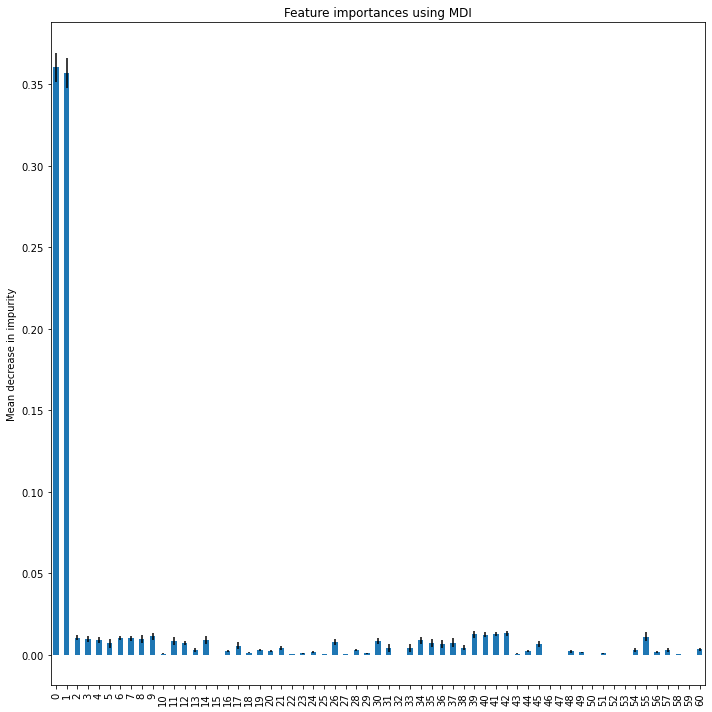

In [115]:
importances = grid_search.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in grid_search.best_estimator_.estimators_], axis=0)

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax, figsize=(10,10))
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Location seems to be most important to predict the severity of an accident.

### KNN

Since both latitude, longitude and the one hot encoded variables do not need to be scaled there is no additional preparation

In [116]:
accuracies = []

for i in range(5, 15):
    classifier = KNeighborsClassifier(n_neighbors = i, metric = 'euclidean')
    print(classifier)
    classifier.fit(X_train, np.ravel(y_train))
    pred_i = classifier.predict(X_test)
    print(np.mean(pred_i ==np.ravel(y_test)))
    accuracies.append(np.mean(pred_i ==np.ravel(y_test)))

KNeighborsClassifier(metric='euclidean')
0.8514260041931512
KNeighborsClassifier(metric='euclidean', n_neighbors=6)
0.8456687410562748
KNeighborsClassifier(metric='euclidean', n_neighbors=7)
0.8573829411960464
KNeighborsClassifier(metric='euclidean', n_neighbors=8)
0.8540883224067357
KNeighborsClassifier(metric='euclidean', n_neighbors=9)
0.8599121434989517
KNeighborsClassifier(metric='euclidean', n_neighbors=10)
0.8581816366601218
KNeighborsClassifier(metric='euclidean', n_neighbors=11)
0.8609770707843855
KNeighborsClassifier(metric='euclidean', n_neighbors=12)
0.8598289460547772
KNeighborsClassifier(metric='euclidean', n_neighbors=13)
0.8615594528936071
KNeighborsClassifier(metric='euclidean', n_neighbors=14)
0.8604612466305035


In [117]:
classifier = KNeighborsClassifier(n_neighbors = 13, metric = 'euclidean')
classifier.fit(X_train, np.ravel(y_train))

KNeighborsClassifier(metric='euclidean', n_neighbors=13)

### NaiveBayes

For naiveBayes scaling does not matter again

In [118]:
gnb = GaussianNB().fit(X_train, y_train.values.ravel())

In [119]:
pred = gnb.predict(X_test)

In [120]:
print('Confusion Matrix: ')
print(confusion_matrix(y_test,pred))

print('\nAccuracy: ')
print(accuracy_score(y_test,pred))

Confusion Matrix: 
[[  763     4     9]
 [ 7363    24   110]
 [50383   146  1296]]

Accuracy: 
0.03466005524310293


## Conclusion

Overall it seems like, based on RandomForest, the biggest impact on the model comes from the location itself. The best Model is kNN, but only by a small margin so this could be somewhat random and due to non-extensive testing of RandomForest due to performance issues.

## Store model

To use the best model later for API inference in the container, we store it via pickle on the hard drive with high compression to save on storage 

In [126]:
filename = '../backend/model/finalized_model.pkl'

joblib.dump(classifier, filename,compress=1)

['../backend/model/finalized_model.pkl']

Test if reading it works:

In [131]:
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test[1:10], y_test[1:10])
print(result)

0.7777777777777778
